In [21]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc

import joblib

# Load Data

In [22]:
df = pd.read_csv("data/Airlines.csv")
df.head()

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay
0,1,CO,269,SFO,IAH,3,15,205,1
1,2,US,1558,PHX,CLT,3,15,222,1
2,3,AA,2400,LAX,DFW,3,20,165,1
3,4,AA,2466,SFO,DFW,3,20,195,1
4,5,AS,108,ANC,SEA,3,30,202,0


# Data Description

 Airline : Flights Company  
 AirportFrom: Flight Origin  
 AirportTo: Flight Destination  
 DayOfWeek: Flight Day  
 Time: Flight Duration  
 Length: Flight Distance  
 Delay: Marks if a flight had delay.

# Data Preparation

In [23]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

In [24]:
del df['id']
del df['flight']

In [25]:
df['dayofweek'] = df['dayofweek'].astype('object')
df.dtypes

airline        object
airportfrom    object
airportto      object
dayofweek      object
time            int64
length          int64
delay           int64
dtype: object

In [26]:
# Creation of new feature
df['airport_mix'] = df['airportfrom'] + ' - ' + df['airportto']

In [27]:
def data_preparation(df):
    df = df.copy()
    df.columns = df.columns.str.lower().str.replace(' ', '_')
    
    categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

    for c in categorical_columns:
        df[c] = df[c].str.lower().str.replace(' ', '_')

    del df['id']
    del df['flight']

    df['dayofweek'] = df['dayofweek'].astype('object')
    df['airport_mix'] = df['airportfrom'] + ' - ' + df['airportto']

    target = 'delay'
    cat = ['airline', 'airportfrom', 'airportto', 'dayofweek','airport_mix']
    num = ['time', 'length']

    return df, target, cat, num

In [28]:
df.isnull().sum()

airline        0
airportfrom    0
airportto      0
dayofweek      0
time           0
length         0
delay          0
airport_mix    0
dtype: int64

# EDA

In [29]:
for col in df.columns:
    print(col)
    print(df[col].unique()[:5])
    print(df[col].nunique())
    print()

airline
['co' 'us' 'aa' 'as' 'dl']
18

airportfrom
['sfo' 'phx' 'lax' 'anc' 'las']
293

airportto
['iah' 'clt' 'dfw' 'sea' 'msp']
293

dayofweek
[3 4 5 6 7]
7

time
[15 20 30 35 40]
1131

length
[205 222 165 195 202]
426

delay
[1 0]
2

airport_mix
['sfo - iah' 'phx - clt' 'lax - dfw' 'sfo - dfw' 'anc - sea']
4190



In [30]:
df['delay'].value_counts(normalize=True)

delay
0    0.554558
1    0.445442
Name: proportion, dtype: float64

## Delay by weekday

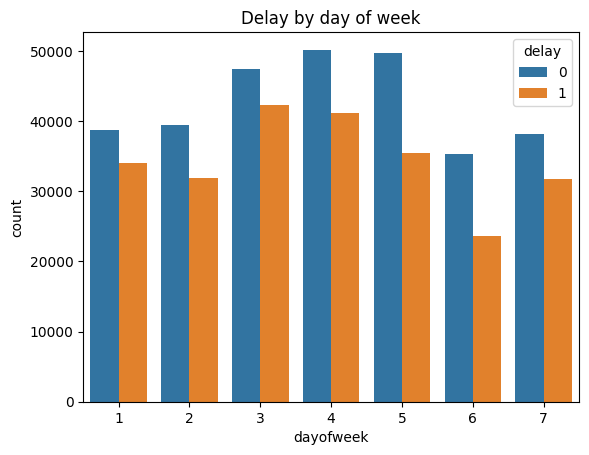

In [31]:
sns.countplot(x='dayofweek', hue='delay', data=df)

plt.title('Delay by day of week')
plt.show()

## Delay by Length

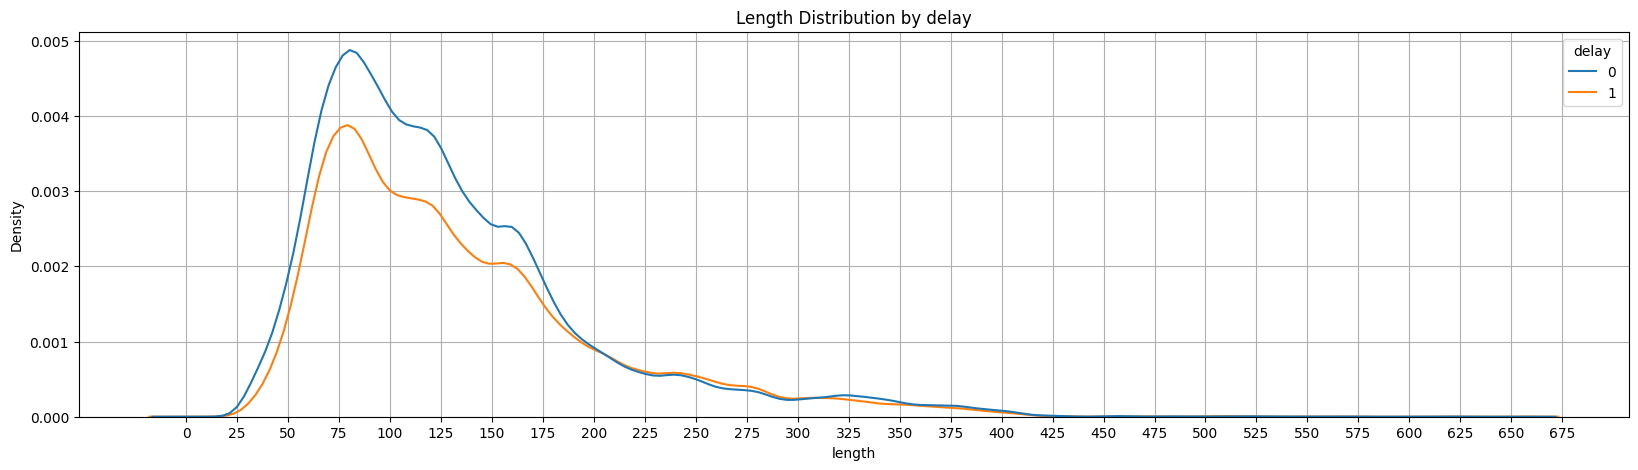

In [32]:
plt.figure(figsize=(20,5))
sns.kdeplot(data=df,x='length'
             ,hue='delay'
             )
custom_xticks = range(min(df['length']), max(df['length']) + 25, 25)
plt.grid()
plt.xticks(custom_xticks)
plt.title('Length Distribution by delay')
plt.show()

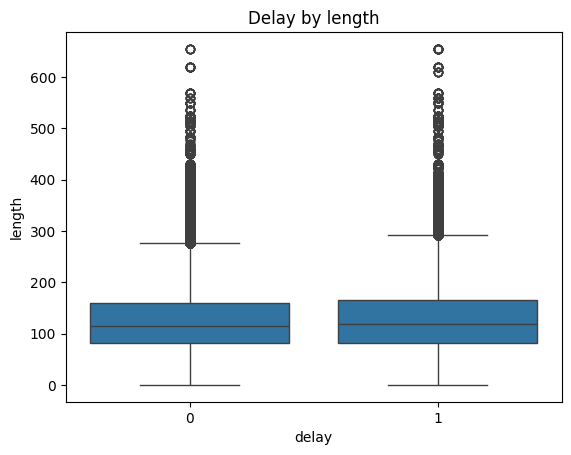

In [33]:
# plt.figure(figsize=(10,15))

sns.boxplot(x='delay',y='length',data=df)
plt.title('Delay by length')
plt.show()

## Delay by airline

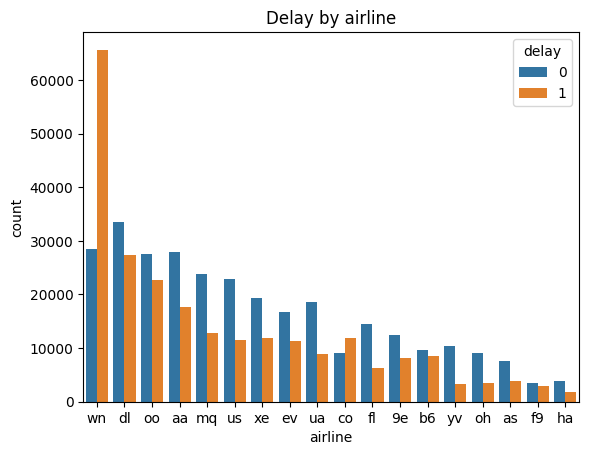

In [34]:
sns.countplot(x='airline', hue='delay', data=df, order=df['airline'].value_counts().index)

plt.title('Delay by airline')
plt.show()

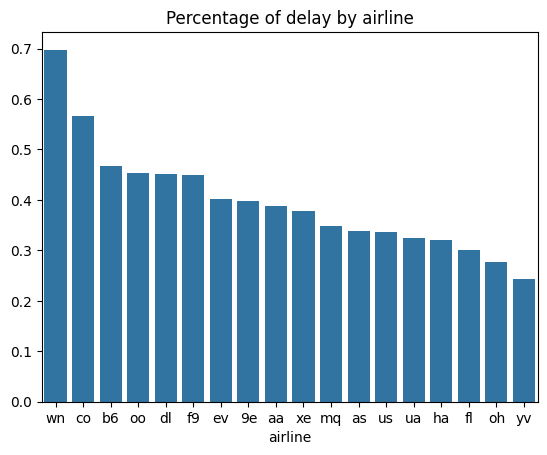

In [35]:
# PErcentage of delay by airline
perc_by_airline = df.groupby('airline')['delay'].mean().sort_values(ascending=False)
sns.barplot(x=perc_by_airline.index, y=perc_by_airline.values)
plt.title('Percentage of delay by airline')
plt.show()

# Delay by origin airport

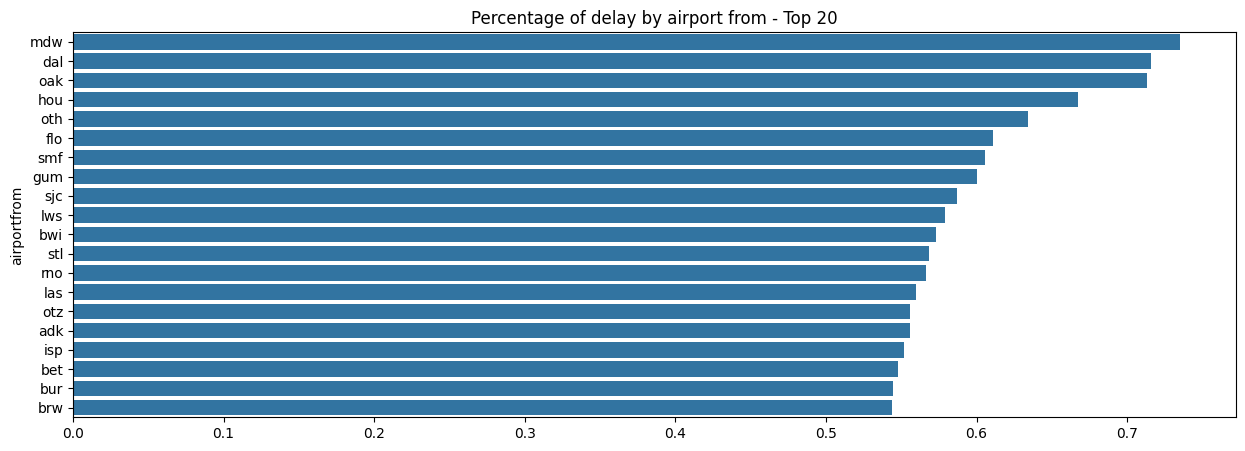

In [36]:
airport_from_delay = df.groupby('airportfrom')['delay'].mean().sort_values(ascending=False)

plt.figure(figsize=(15, 5))
sns.barplot(y=airport_from_delay[:20].index, x=airport_from_delay[:20].values)
plt.title('Percentage of delay by airport from - Top 20')
plt.show()

# Delay by Destination Airport

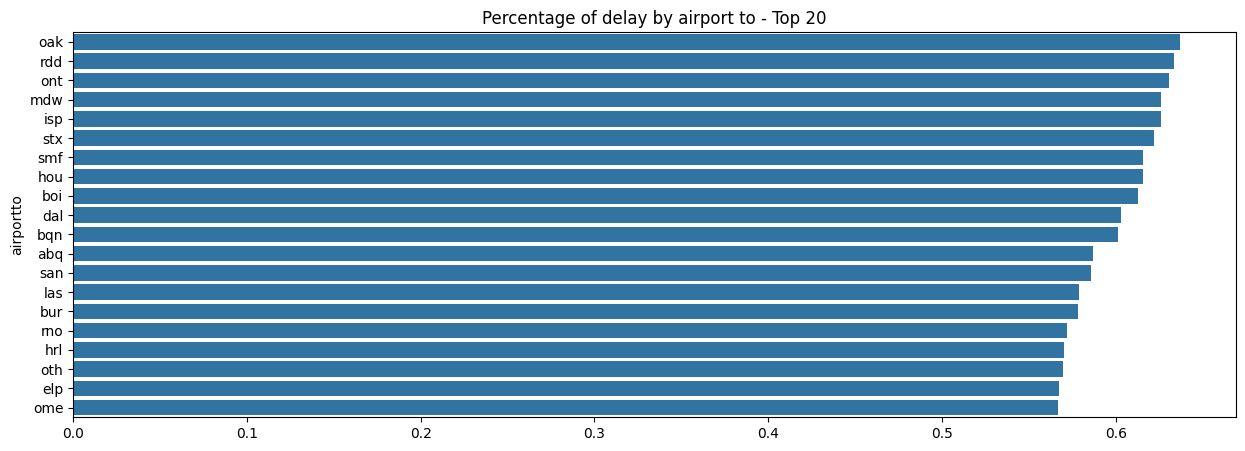

In [37]:
airport_to_delay = df.groupby('airportto')['delay'].mean().sort_values(ascending=False)

plt.figure(figsize=(15, 5))
sns.barplot(y=airport_to_delay[:20].index, x=airport_to_delay[:20].values)
plt.title('Percentage of delay by airport to - Top 20')
plt.show()

## Delay by mix of airports

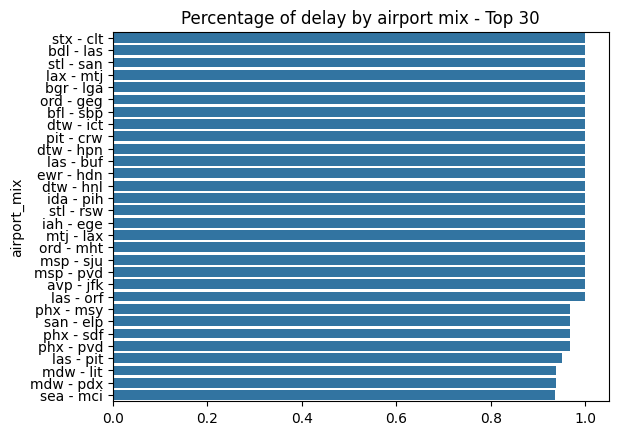

In [38]:
airport_mix_delay = df.groupby('airport_mix')['delay'].mean().sort_values(ascending=False)
sns.barplot(y=airport_mix_delay[:30].index, x=airport_mix_delay[:30].values)

plt.title('Percentage of delay by airport mix - Top 30')
plt.show()

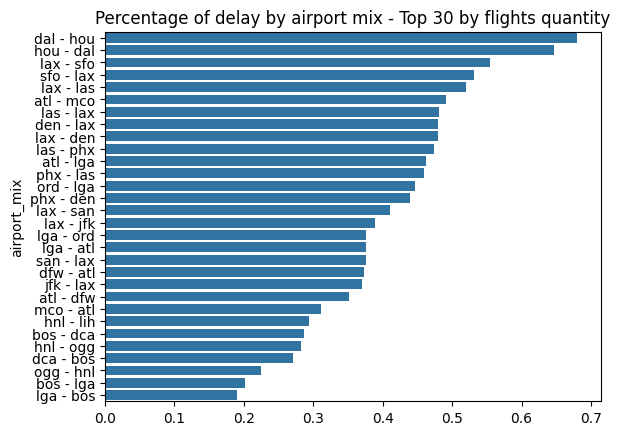

In [39]:
df_mix_count = df['airport_mix'].value_counts()[:30]
# Count plot top 30 airport mix by delay count
df_mix_delay = df[df['airport_mix'].isin(df_mix_count.index)].groupby('airport_mix')['delay'].mean().sort_values(ascending=False)
sns.barplot(y=df_mix_delay.index, x=df_mix_delay.values)

plt.title('Percentage of delay by airport mix - Top 30 by flights quantity')
plt.show()

In [40]:
df.head()

,airline,airportfrom,airportto,dayofweek,time,length,delay,airport_mix
0,co,sfo,iah,3,15,205,1,sfo - iah
1,us,phx,clt,3,15,222,1,phx - clt
2,aa,lax,dfw,3,20,165,1,lax - dfw
3,aa,sfo,dfw,3,20,195,1,sfo - dfw
4,as,anc,sea,3,30,202,0,anc - sea


# Data Splitting

In [41]:
target = 'delay'
cat = ['airline', 'airportfrom', 'airportto', 'dayofweek','airport_mix']
num = ['time', 'length']

In [42]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [43]:
df_full_train = df_full_train.reset_index(drop=True)
y_full_train = df_full_train[target].values
del df_full_train[target]

In [44]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [45]:
len(df_train), len(df_val), len(df_test)

(323629, 107877, 107877)

In [46]:
y_train = df_train[target].values
y_val = df_val[target].values
y_test = df_test[target].values

del df_train[target]
del df_val[target]
del df_test[target]

In [47]:
df_train.head()

,airline,airportfrom,airportto,dayofweek,time,length,airport_mix
0,wn,rno,pdx,5,1050,90,rno - pdx
1,xe,ewr,dca,4,1185,76,ewr - dca
2,oh,dtw,cvg,1,1165,81,dtw - cvg
3,wn,stl,las,3,430,235,stl - las
4,co,iah,lga,7,478,201,iah - lga


In [48]:
train_dicts = df_train.to_dict(orient='records')

In [49]:
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

In [50]:
dv

DictVectorizer(sparse=False)

In [51]:
components_test = [5, 10, 20, 30, 40, 50]
n_fold = 5  # Número de divisiones en K-fold cross-validation
kf = KFold(n_splits=n_fold, shuffle=True, random_state=42)

In [ ]:
kf

In [ ]:
results_pca = []

for n_components in components_test:
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train)
    modelo = RandomForestClassifier(n_jobs=-1)
    scores = cross_val_score(modelo, X_train_pca, y_train, cv=kf, scoring='accuracy')
    average_score = np.mean(scores)
    results_pca.append((n_components, average_score))
    print(n_components,average_score)

# Encuentra el número óptimo de componentes con el mejor rendimiento
best_result = max(results_pca, key=lambda x: x[1])
n_components_opt = best_result[0]


5 0.6172345523734737  
10 0.6192584732048185  
20 0.6185601404271148  
30 0.618013219465214  
40 0.6176609645840235  
50 0.6165423985855126  

In [55]:
n_components_opt = 10
pca = PCA(n_components=n_components_opt)
X_train_pca = pca.fit_transform(X_train)

# Model

## Random Forest

In [57]:
#Save array to csv

# np.savetxt("data/X_train_pca.csv", X_train_pca, delimiter=",")

In [58]:
X_train_pca = np.genfromtxt("data/X_train_pca.csv", delimiter=",")
X_train_pca

array([[-2.46753849e+02, -4.07456049e+01, -1.08343568e+00, ...,
        -2.65939210e-02,  3.84800305e-03, -1.46387556e-02],
       [-3.81829849e+02, -5.39920082e+01, -8.75168093e-02, ...,
        -2.36616421e-01,  5.22688403e-01, -4.53523521e-01],
       [-3.61802242e+02, -4.91049310e+01,  2.91363174e+00, ...,
        -2.82479699e-03,  5.16592852e-03, -7.43324819e-02],
       ...,
       [ 9.93010571e+01,  1.47325748e+02, -1.49809504e-02, ...,
        -9.03598253e-02, -2.23471566e-03,  1.02337871e-01],
       [-5.30622176e+02,  1.62842056e+02, -1.00338618e+00, ...,
         5.92962782e-01, -3.82606471e-01, -9.66895801e-02],
       [-1.56420361e+02,  1.87497736e+01,  2.93833946e+00, ...,
        -5.98092563e-02,  1.38316814e-03,  8.57705917e-02]])

In [59]:
rf = RandomForestClassifier(random_state=42)

rf.fit(X_train_pca, y_train)

RandomForestClassifier(random_state=42)

In [60]:
val_dicts = df_val.to_dict(orient='records')
X_val = dv.transform(val_dicts)
X_val_pca = pca.transform(X_val)

y_pred = rf.predict_proba(X_val_pca)[:, 1]
roc_auc_score(y_val, y_pred)


0.6733833688286281

## Model Tunning

### n_estimators

In [61]:
n_estimators = [10, 20, 50, 100, 200]

results_rf = []
for n_estimator in n_estimators:
    rf = RandomForestClassifier(n_estimators=n_estimator, random_state=42, n_jobs=-1)
    rf.fit(X_train_pca, y_train)
    y_pred = rf.predict_proba(X_val_pca)[:, 1]
    score = roc_auc_score(y_val, y_pred)
    results_rf.append((n_estimator, score))
    print(n_estimator,score)

10 0.6587587359843388
20 0.6660329826204994
50 0.671063818921886
100 0.673383444321294
200 0.6742692140341311


In [62]:
results_rf

[(10, 0.6587587359843388),
 (20, 0.6660329826204994),
 (50, 0.671063818921886),
 (100, 0.673383444321294),
 (200, 0.6742692140341311)]

In [63]:
best_estimator = 50

### Max depth

In [64]:
max_depths = [5, 10, 15, 20, 30]

results_rf_depth = []

for max_depth in max_depths:
    rf = RandomForestClassifier(n_estimators=best_estimator, max_depth=max_depth, random_state=42, n_jobs=-1)
    rf.fit(X_train_pca, y_train)
    y_pred = rf.predict_proba(X_val_pca)[:, 1]
    score = roc_auc_score(y_val, y_pred)
    results_rf_depth.append((max_depth, score))
    print(max_depth,score)

5 0.6807074124450063
10 0.7045994466818974
15 0.7137084390652475
20 0.7005038895404394
30 0.6758829755274938


In [65]:
best_max_depth = 15

### Min Samples Split

In [66]:
min_samples_splits = [2, 5, 10, 15, 20]

results_rf_split = []

for min_samples_split in min_samples_splits:
    rf = RandomForestClassifier(n_estimators=best_estimator, max_depth=best_max_depth, min_samples_split=min_samples_split, random_state=42, n_jobs=-1)
    rf.fit(X_train_pca, y_train)
    y_pred = rf.predict_proba(X_val_pca)[:, 1]
    score = roc_auc_score(y_val, y_pred)
    results_rf_split.append((min_samples_split, score))
    print(min_samples_split,score)

2 0.7137084390652476
5 0.713878939947014
10 0.714793039761281
15 0.7146835682639004
20 0.7147773527679843


In [67]:
best_min_samples_split = 20

### Min Samples Leaf

In [68]:
min_samples_leafs = [1, 2, 5, 10, 15]

results_rf_leaf = []

for min_samples_leaf in min_samples_leafs:
    rf = RandomForestClassifier(n_estimators=best_estimator, max_depth=best_max_depth, min_samples_split=best_min_samples_split, min_samples_leaf=min_samples_leaf, random_state=42, n_jobs=-1)
    rf.fit(X_train_pca, y_train)
    y_pred = rf.predict_proba(X_val_pca)[:, 1]
    score = roc_auc_score(y_val, y_pred)
    results_rf_leaf.append((min_samples_leaf, score))
    print(min_samples_leaf,score)

1 0.7147773527679843
2 0.7152611661297834
5 0.7157764578459164
10 0.716153001869668
15 0.7165875117367178


In [69]:
best_min_samples_leaf = 10

## Best model

In [70]:
rf = RandomForestClassifier(n_estimators=best_estimator, max_depth=best_max_depth, min_samples_split=best_min_samples_split, min_samples_leaf=best_min_samples_leaf, random_state=42, n_jobs=-1)
rf.fit(X_train_pca, y_train)
y_pred = rf.predict_proba(X_val_pca)[:, 1]

In [71]:
from sklearn.metrics import accuracy_score

# Measuring the accuracy of the model
accuracy_score(y_val, y_pred.round())

0.6654523206985734

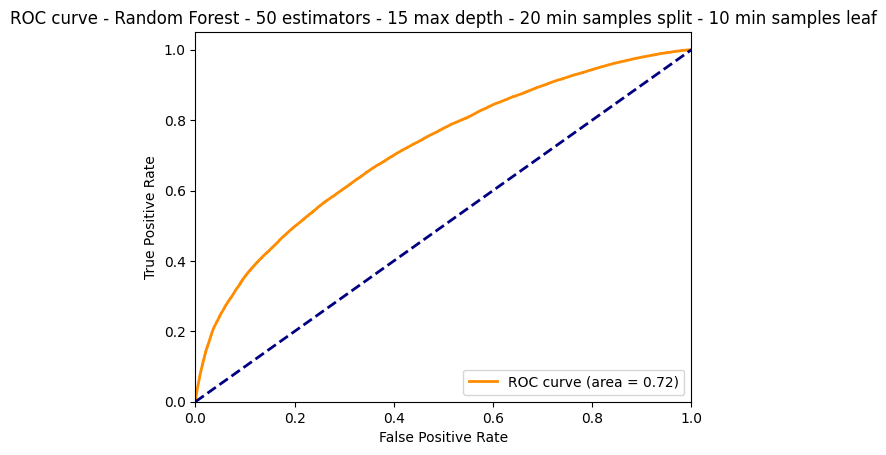

In [72]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC curve - Random Forest - {best_estimator} estimators - {best_max_depth} max depth - {best_min_samples_split} min samples split - {best_min_samples_leaf} min samples leaf')
plt.legend(loc='lower right')
plt.show()

In [73]:
def tpr_fpr_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)
    
    return df_scores

In [74]:
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()
num_neg, num_pos

y_ideal = np.repeat([0, 1], [num_neg, num_pos])
y_ideal

y_ideal_pred = np.linspace(0, 1, len(y_val))

df_ideal = tpr_fpr_dataframe(y_ideal, y_ideal_pred)

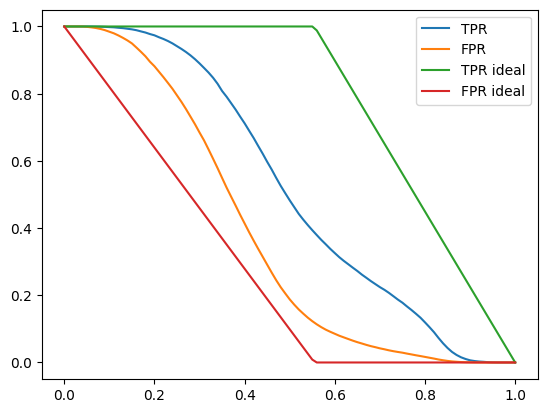

In [75]:
df_val_eval = tpr_fpr_dataframe(y_val, y_pred)

plt.plot(df_val_eval.threshold, df_val_eval['tpr'], label='TPR')
plt.plot(df_val_eval.threshold, df_val_eval['fpr'], label='FPR')

plt.plot(df_ideal.threshold, df_ideal['tpr'], label='TPR ideal')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label='FPR ideal')

plt.legend()

# Save the model

In [76]:
import pickle

In [77]:
dv

DictVectorizer(sparse=False)

In [78]:
pca

PCA(n_components=10)

In [79]:
rf

RandomForestClassifier(max_depth=15, min_samples_leaf=10, min_samples_split=20,
                       n_estimators=50, n_jobs=-1, random_state=42)

In [80]:
output_file = 'model1.0.bin'

f_out = open(output_file, 'wb')
pickle.dump((dv, pca, rf), f_out)
f_out.close()

# Load Model

In [81]:
input_file = 'model1.0.bin'

# Load the model from the pickle file
with open(input_file, 'rb') as f_in: 
    dv, pca, rf = pickle.load(f_in)


In [82]:
dv

DictVectorizer(sparse=False)

In [83]:
# generate a random integer from 0 to len(df_test)

sample = np.random.randint(0, len(df_test))
sample

89953

In [84]:
flight = df_test.iloc[sample]
# .to_dict(orient='records')[0]
flight

airline               ev
airportfrom          xna
airportto            mem
dayofweek              5
time                 700
length                66
airport_mix    xna - mem
Name: 89953, dtype: object

In [85]:
# flight ={
#     'airline' : 'us',
#     'airportfrom' : 'bwi',
#     'airportto' : 'clt',
#     'dayofweek' : 4,
#     'time' : 325,
#     'length' : 83,
#     'airport_mix' : 'bwi - clt'
# }

In [86]:
X_test = dv.transform([flight])
X_test_pca = pca.transform(X_test)
y_pred = rf.predict_proba(X_test_pca)[0, 1]
y_pred

0.1985541016355616

In [87]:
y_test[sample]

0